# **Working on Images Dataset**

In [ ]:
import pandas as pd
import matplotlib as mat
import seaborn as sns

In [ ]:
!pip install -q tfds-nightly tensorflow matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 33.8 MB/s eta 0:00:00


In [ ]:
#tfds.list_builders()
builder = tfds.builder('pneumonia_mnist')
# 1. Create the tfrecord files (no-op if already exists)
builder.download_and_prepare()
# 2. Load the `tf.data.Dataset`
ds = builder.as_dataset(split='train', shuffle_files=True)
print(ds)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/pneumonia_mnist/incomplete.RKYIR6_1.0.0/pneumonia_mnist-train.tfrecord*...…

Generating val examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/pneumonia_mnist/incomplete.RKYIR6_1.0.0/pneumonia_mnist-val.tfrecord*...: …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/pneumonia_mnist/incomplete.RKYIR6_1.0.0/pneumonia_mnist-test.tfrecord*...:…

Dataset pneumonia_mnist downloaded and prepared to /root/tensorflow_datasets/pneumonia_mnist/1.0.0. Subsequent calls will reuse this data.
<_PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


{'image': <tf.Tensor: shape=(28, 28, 1), dtype=uint8, numpy=
array([[[141],
        [139],
        [123],
        [109],
        [110],
        [115],
        [129],
        [151],
        [172],
        [186],
        [207],
        [222],
        [226],
        [223],
        [223],
        [226],
        [227],
        [233],
        [222],
        [202],
        [183],
        [162],
        [150],
        [155],
        [127],
        [130],
        [135],
        [141]],

       [[126],
        [132],
        [125],
        [118],
        [120],
        [122],
        [131],
        [149],
        [163],
        [175],
        [195],
        [211],
        [216],
        [214],
        [215],
        [218],
        [221],
        [224],
        [210],
        [185],
        [164],
        [140],
        [126],
        [130],
        [136],
        [133],
        [132],
        [135]],

       [[128],
        [131],
        [123],
        [120],
        [127],
        [126],
     

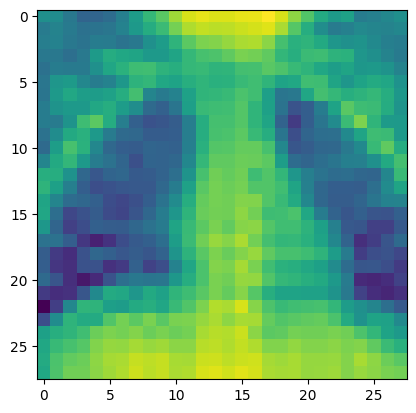

In [ ]:
# show image in numbers
images = ds.take(1)
for example in images:
  print(example)

#Extracts the image data as a NumPy array.
example = example["image"].numpy()
plt.imshow(example)

#Loading Data as Supervised (Image, Label) Pairs
ds = tfds.load('pneumonia_mnist', split='train', as_supervised=True)
ds = ds.take(10)
for image, label in ds:  # example is (image, label)
  print(image.shape, label)
#(28, 28, 1) tf.Tensor(0, shape=(), dtype=int64)  eg: output

In [ ]:
# Load dataset with access to the metadata
ds, info = tfds.load('pneumonia_mnist', with_info=True)
builder = tfds.builder('pneumonia_mnist')
info = builder.info
print(info)


tfds.core.DatasetInfo(
    name='pneumonia_mnist',
    full_name='pneumonia_mnist/1.0.0',
    description="""
    # MedMNIST Pneumonia Dataset
    
    The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray
    images. The task is binary-class classification of pneumonia against normal. The
    source training set is split with a ratio of 9:1 into training and validation
    set, and use its source validation set as the test set. The source images are
    gray-scale, and their sizes are (384–2,916) × (127–2,713). The images are
    center-cropped with a window size of length of the short edge and resized into 1
    × 28 × 28.
    """,
    homepage='https://medmnist.com//',
    data_dir='/root/tensorflow_datasets/pneumonia_mnist/1.0.0',
    file_format=tfrecord,
    download_size=3.98 MiB,
    dataset_size=3.66 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),

In [ ]:
# Load training set as dataframe
df_train, info_train = tfds.load('pneumonia_mnist', split='train', with_info=True)

tfds.as_dataframe(df_train.take(5), info_train)
len(df_train)
#for example in df_train:
 # print(example)

4708

In [ ]:
# Load test set as dataframe
df_test, info_test = tfds.load('pneumonia_mnist', split='test', with_info=True)

tfds.as_dataframe(df_test.take(5), info_test)
len(df_test)
#for exapmle in df_test:
#  print(example)


624

# **Classification model(CNN) in which the input is the raw image and the output is the normal/ill label.**

**Dataset Info**

5,856 pediatric chest X-Ray

Splits: 90% training, 10% validation, 10% test and the source validation set used for testing.

Shape: (28, 28, 1) (Grayscale)

Data Type: uint8

Number of Classes: 2 (Normal, Pneumonia)



Prepare and Normalize the Data

In [ ]:
# Load the dataset
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'pneumonia_mnist',
    split=['train', 'val', 'test'],
    as_supervised=True,  # Ensures data is loaded as (image, label) pairs
    with_info=True
)

# Normalize the images (Rescale pixel values to [0, 1])
def normalize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label

ds_train = ds_train.map(normalize_img).cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.map(normalize_img).cache().batch(32).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(normalize_img).cache().batch(32).prefetch(tf.data.AUTOTUNE)

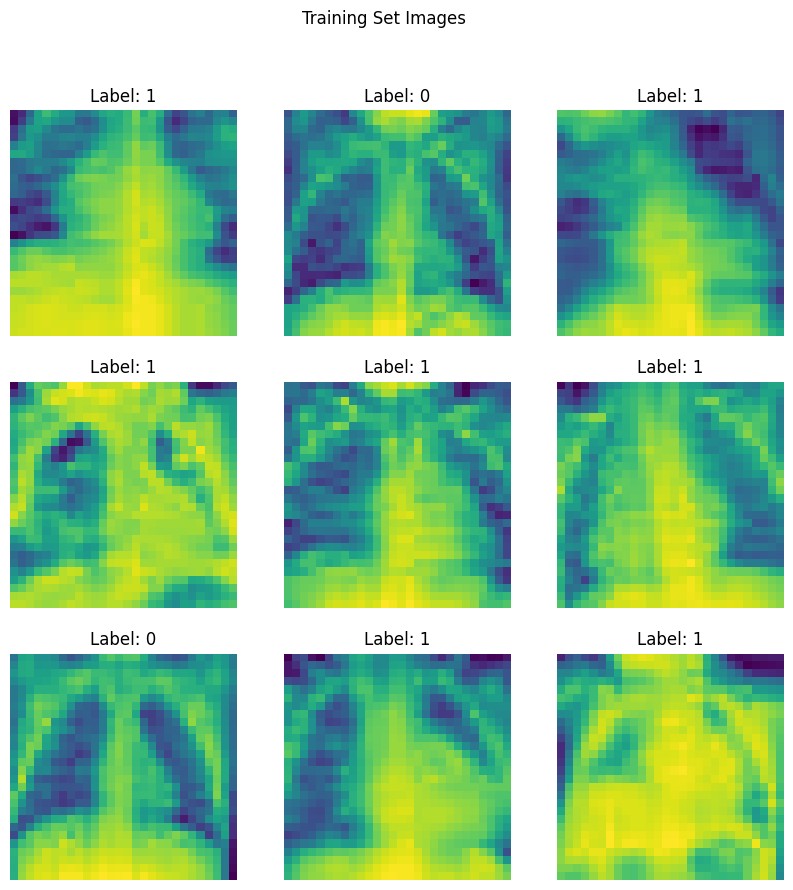

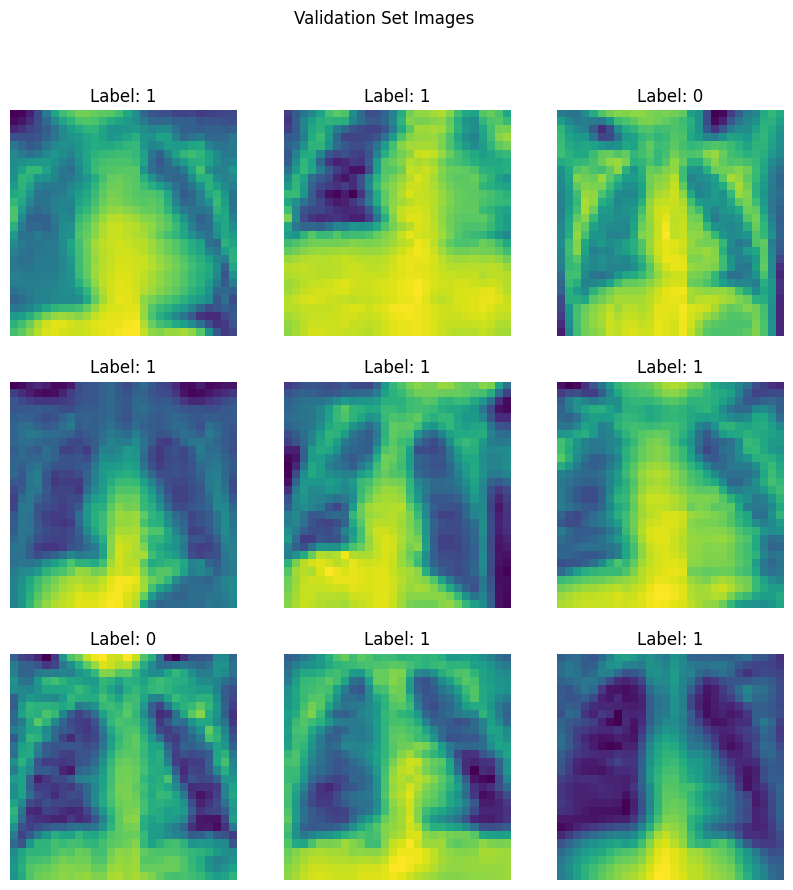

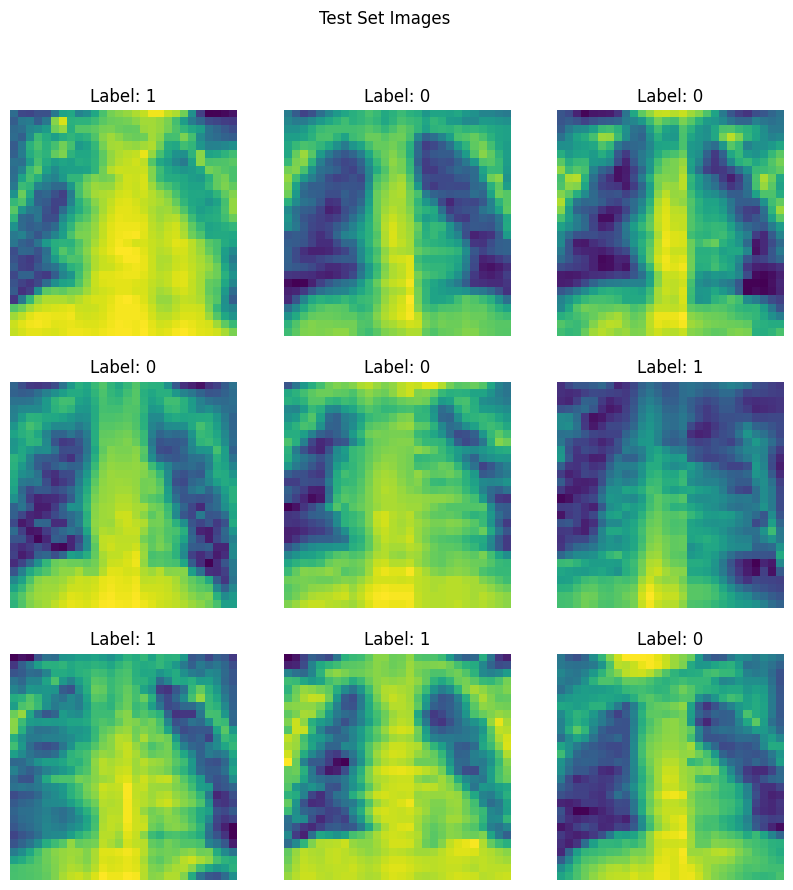

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Function to display a batch of images
def display_images(dataset, title="Images"):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(1)):  # Take a single batch
        for j in range(9):  # Display 9 images from the batch
            ax = plt.subplot(3, 3, j+1)
            plt.imshow(image[j].numpy())  # Convert tensor to numpy for display
            plt.title(f"Label: {label[j].numpy()}")
            plt.axis("off")
    plt.suptitle(title)
    plt.show()

# Display images from the training, validation, and test sets
display_images(ds_train, title="Training Set Images")
display_images(ds_val, title="Validation Set Images")
display_images(ds_test, title="Test Set Images")


Build CNN Model

In [ ]:
# Define the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='sigmoid')  # Output layer for binary classification
])

# Get the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)                   │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 240,514 (939.51 KB)

 Trainable params: 240,514 (939.51 KB)

 Non-trainable params: 0 (0.00 B)

Compile and train the model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Stop training if no improvement for 5 consecutive epochs
    restore_best_weights=True  # Restore the best weights after stopping
)

# Define ModelCheckpoint to save the best model weights based on validation accuracy
checkpoint = ModelCheckpoint(
    'Cnn_best_weights.keras',  # Save the best model weights to this file
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,  # Save only the best weights
    mode='max',  # Save weights when the accuracy is maximized
    verbose=1  # Print a message when saving the weights
)

# Train the model
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=100,
    callbacks=[early_stopping, checkpoint]  # Add both EarlyStopping and ModelCheckpoint
)

# Optionally, save the final model (this can be the last epoch's weights)
#model.save('cnn_model_final.h5')  # Save in .h5 format (or use .keras)


Epoch 1/100
146/148 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9664 - loss: 0.0889
Epoch 1: val_accuracy improved from -inf to 0.97137, saving model to Cnn_best_weights.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.9663 - loss: 0.0889 - val_accuracy: 0.9714 - val_loss: 0.0818
Epoch 2/100
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9659 - loss: 0.0861
Epoch 2: val_accuracy did not improve from 0.97137
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9660 - loss: 0.0861 - val_accuracy: 0.9561 - val_loss: 0.0897
Epoch 3/100
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9713 - loss: 0.0784
Epoch 3: val_accuracy improved from 0.97137 to 0.97901, saving model to Cnn_best_weights.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.9713 - loss: 0.0784 - val_accuracy: 0.9790 - val_loss: 0.0703
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9773 - loss: 0.0676
Epoch 4: val_accuracy improved from 0.97901 to 0.98092,

Plot Training and Validation Accuracy,

Calculate Precision, Recall, F1 Score, and Accuracy per Class.


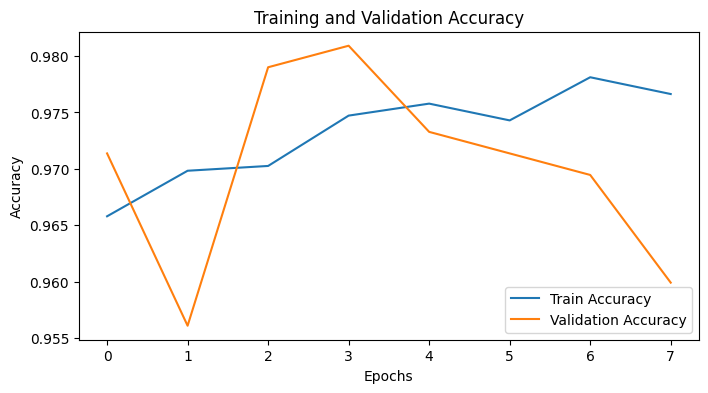

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Accuracy: 86.06%
Precision per class: [0.95092025 0.82863341]
Recall per class: [0.66239316 0.97948718]
F1 score per class: [0.78085642 0.89776733]


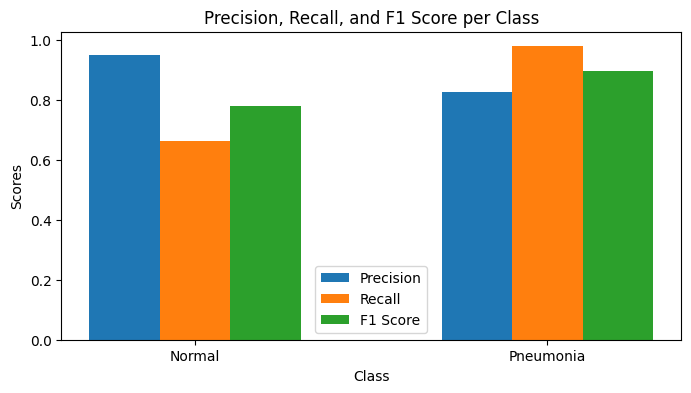

In [ ]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Get model predictions on the test set
y_true = []
y_pred = []

for image, label in ds_test:
    y_true.extend(label.numpy())
    y_pred.extend(tf.argmax(model.predict(image), axis=1).numpy())

# Calculate overall accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision, recall, and F1 score per class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

# Print the results
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision per class: {precision}")
print(f"Recall per class: {recall}")
print(f"F1 score per class: {f1}")

# Plot Precision, Recall, and F1 score per class
classes = ['Normal', 'Pneumonia']
bar_width = 0.2
index = np.arange(len(classes))

fig, ax = plt.subplots(figsize=(8, 4))
bar1 = ax.bar(index, precision, bar_width, label='Precision')
bar2 = ax.bar(index + bar_width, recall, bar_width, label='Recall')
bar3 = ax.bar(index + 2 * bar_width, f1, bar_width, label='F1 Score')

ax.set_xlabel('Class')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1 Score per Class')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(classes)
ax.legend()

plt.show()



Plot Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


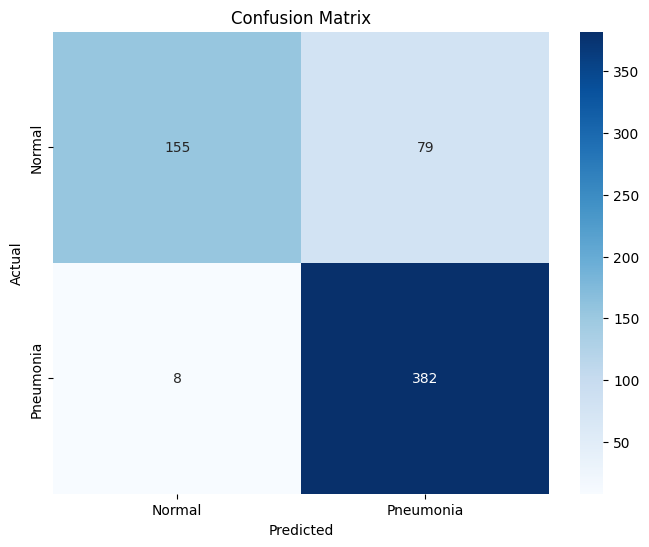

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get model predictions on the test set
y_true = []
y_pred = []

for image, label in ds_test:
    y_true.extend(label.numpy())
    y_pred.extend(tf.argmax(model.predict(image), axis=1).numpy())

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



# **A generative model, in which the input is a noisy image and the output is a clean image.**

Add Artificial Gaussian Noise to Dataset

In [ ]:
# Function to add Gaussian noise to an image
def add_gaussian_noise(image, label, mean=0.0, stddev=0.1):
    noise = tf.random.normal(shape=tf.shape(image), mean=mean, stddev=stddev, dtype=tf.float32)
    noisy_image = tf.clip_by_value(image + noise, 0.0, 1.0)  # Ensure pixel values remain in [0, 1]
    return noisy_image, label

# Create noisy datasets without affecting the original clean images
ds_train_noisy = ds_train.map(lambda img, lbl: add_gaussian_noise(img, lbl, mean=0.0, stddev=0.1))
ds_val_noisy = ds_val.map(lambda img, lbl: add_gaussian_noise(img, lbl, mean=0.0, stddev=0.1))
ds_test_noisy = ds_test.map(lambda img, lbl: add_gaussian_noise(img, lbl, mean=0.0, stddev=0.1))


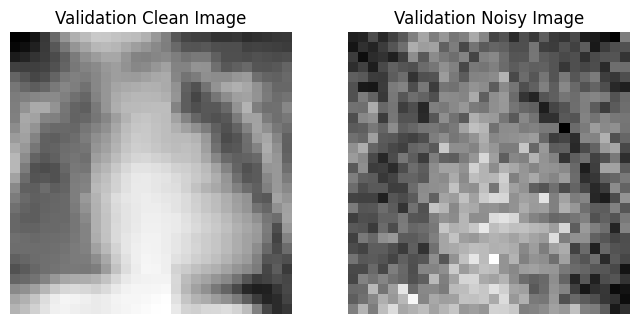

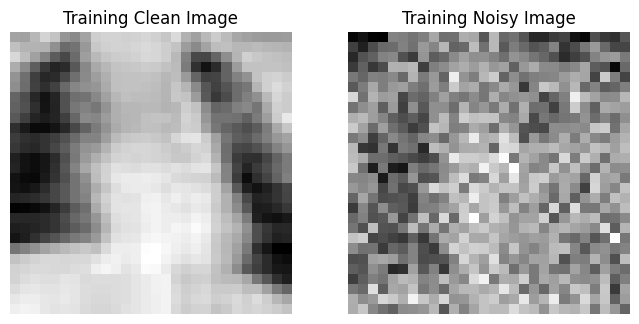

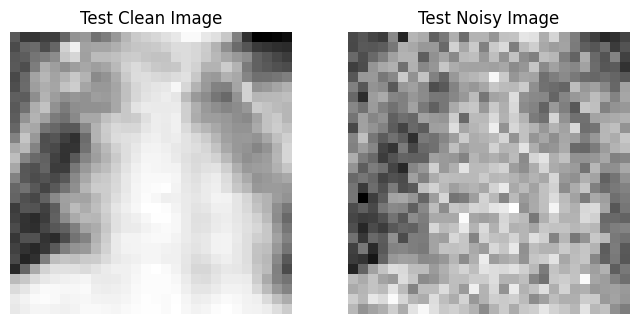

In [ ]:
# Verify by inspecting a few examples (optional)
import matplotlib.pyplot as plt
import tensorflow as tf

# Function to visualize the comparison
def visualize_comparison(noisy_dataset, clean_dataset, dataset_name):
    # Take a single example from both noisy and clean datasets
    noisy_image, _ = next(iter(noisy_dataset))
    clean_image, _ = next(iter(clean_dataset))

    # Plot the images
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(clean_image[0].numpy().astype("float32"), cmap='gray')
    plt.title(f'{dataset_name} Clean Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(noisy_image[0].numpy().astype("float32"), cmap='gray')
    plt.title(f'{dataset_name} Noisy Image')
    plt.axis('off')

    plt.show()

# Visualize for validation dataset
visualize_comparison(ds_val_noisy, ds_val, 'Validation')
# Visualize for training dataset
visualize_comparison(ds_train_noisy, ds_train, 'Training')
# Visualize for test dataset
visualize_comparison(ds_test_noisy, ds_test, 'Test')


Convolutional Autoencoder (consist 2 part encoder and decoder)

Encoder: Compresses the noisy image into a latent representation.

Decoder: Reconstructs the clean image from the latent representation.

In [ ]:
from tensorflow.keras import layers
import tensorflow as tf

def create_autoencoder():
    # Encoder
    encoder_input = layers.Input(shape=(28, 28, 1))  # Image shape (28x28x1)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)  # (14, 14, 32)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)  # (7, 7, 64)

    # Latent space (compressed representation)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)  # (4, 4, 128)

    # Decoder
    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)  # (8, 8, 128)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)  # (16, 16, 64)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)  # (32, 32, 32)

    # Crop the output to (28, 28)
    x = layers.Cropping2D(cropping=((2, 2), (2, 2)))(x)  # Crop to (28, 28, 1)

    decoded = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)  # Output shape (28x28x1)

    # Autoencoder model
    autoencoder = tf.keras.Model(encoder_input, decoded)
    return autoencoder




autoencoder = create_autoencoder()
autoencoder.summary()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_28                  │ (None, 4, 4, 128)           │         147,584 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_16 (UpSampling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_29                  │ (None, 8, 8, 64)            │          73,792 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_17 (UpSampling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_30                  │ (None, 16, 16, 32)          │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_18 (UpSampling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping2d_1 (Cropping2D)            │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_31                  │ (None, 28, 28, 1)           │             289 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 332,801 (1.27 MB)

 Trainable params: 332,801 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss='mse')

# Define EarlyStopping for the autoencoder
early_stopping_autoencoder = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Stop training if no improvement for 5 consecutive epochs
    restore_best_weights=True  # Restore the best weights after stopping
)

# Define ModelCheckpoint to save the best autoencoder weights based on validation loss
checkpoint_autoencoder = ModelCheckpoint(
    'Autoencoder_best_weights.keras',  # Save the best model weights to this file
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True,  # Save only the best weights
    mode='min',  # Save weights when the loss is minimized
    verbose=1  # Print a message when saving the weights
)

# Extract noisy and clean images for training
def get_noisy_and_clean_images(dataset_noisy, dataset_clean):
    noisy_images = []
    clean_images = []
    for noisy, clean in zip(dataset_noisy, dataset_clean):
        noisy_images.append(noisy[0].numpy())  # Noisy image
        clean_images.append(clean[0].numpy())  # Clean image
    # Convert lists to numpy arrays after the loop
    return np.concatenate(noisy_images), np.concatenate(clean_images)

# Convert noisy and clean datasets into numpy arrays
noisy_train, clean_train = get_noisy_and_clean_images(ds_train_noisy, ds_train)
noisy_val, clean_val = get_noisy_and_clean_images(ds_val_noisy, ds_val)

# Train the autoencoder
autoencoder.fit(
    noisy_train, clean_train,
    epochs=500,  # Adjust number of epochs
    batch_size=32,
    validation_data=(noisy_val, clean_val),
    callbacks=[early_stopping_autoencoder, checkpoint_autoencoder]  # Add both EarlyStopping and ModelCheckpoint
)

# Optionally, save the final autoencoder model (this can be the last epoch's weights)
#autoencoder.save('autoencoder_final_model.keras')  # Save in .keras format


Epoch 1/500
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.0201
Epoch 1: val_loss improved from inf to 0.01707, saving model to Autoencoder_best_weights.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 30s 170ms/step - loss: 0.0200 - val_loss: 0.0171
Epoch 2/500
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0171
Epoch 2: val_loss did not improve from 0.01707
148/148 ━━━━━━━━━━━━━━━━━━━━ 25s 170ms/step - loss: 0.0171 - val_loss: 0.0172
Epoch 3/500
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0172
Epoch 3: val_loss improved from 0.01707 to 0.01679, saving model to Autoencoder_best_weights.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 41s 170ms/step - loss: 0.0172 - val_loss: 0.0168
Epoch 4/500
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0174
Epoch 4: val_loss did not improve from 0.01679
148/148 ━━━━━━━━━━━━━━━━━━━━ 25s 171ms/step - loss: 0.0174 - val_loss: 0.0172
Epoch 5/500
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0172
Epoch 5: val_loss did not improve from 0.01679
148

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0164
Test Loss: 0.01643339917063713
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


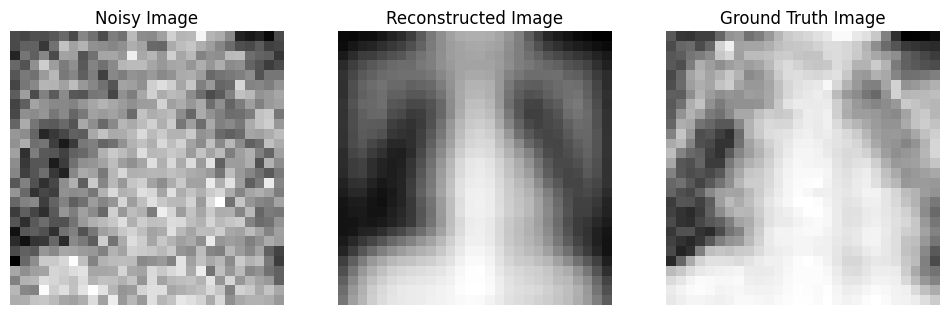

In [ ]:
noisy_test, clean_test = get_noisy_and_clean_images(ds_test_noisy, ds_test)

# Evaluate the model on the test set
test_loss = autoencoder.evaluate(noisy_test, clean_test)
print(f"Test Loss: {test_loss}")


# Function to visualize results
def visualize_reconstruction(model, noisy_image, clean_image):
    reconstructed_image = model.predict(noisy_image[np.newaxis, ...])[0]  # Add batch dimension for prediction
    plt.figure(figsize=(12, 4))
    # Original noisy image
    plt.subplot(1, 3, 1)
    plt.imshow(noisy_image.squeeze(), cmap='gray')
    plt.title("Noisy Image")
    plt.axis('off')
    # Reconstructed clean image
    plt.subplot(1, 3, 2)
    plt.imshow(reconstructed_image.squeeze(), cmap='gray')
    plt.title("Reconstructed Image")
    plt.axis('off')
    # Ground truth clean image
    plt.subplot(1, 3, 3)
    plt.imshow(clean_image.squeeze(), cmap='gray')
    plt.title("Ground Truth Image")
    plt.axis('off')
    plt.show()

# Visualize a noisy image and its reconstruction
visualize_reconstruction(autoencoder, noisy_test[0], clean_test[0])


In [ ]:
import tensorflow as tf
import numpy as np

# Function to compute RMSE
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# Function to compute Relative RMSE
def relative_rmse(y_true, y_pred):
    rmse_value = rmse(y_true, y_pred)
    range_of_values = 1.0  # For images with pixel values in the range [0, 1]
    return rmse_value / range_of_values

# Example: Calculate RMSE and Relative RMSE for the test set
noisy_test, clean_test = get_noisy_and_clean_images(ds_test_noisy, ds_test)

# Predictions from the autoencoder model
reconstructed_images = autoencoder.predict(noisy_test)

# Calculate RMSE and Relative RMSE for each image in the batch
rmse_values = [rmse(clean_test[i], reconstructed_images[i]) for i in range(len(clean_test))]
relative_rmse_values = [relative_rmse(clean_test[i], reconstructed_images[i]) for i in range(len(clean_test))]

# Average RMSE and Relative RMSE
avg_rmse = np.mean(rmse_values)
avg_relative_rmse = np.mean(relative_rmse_values)

print(f"Average RMSE: {avg_rmse:.4f}")
print(f"Average Relative RMSE: {avg_relative_rmse:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
Average RMSE: 0.1221
Average Relative RMSE: 0.1221


# **Working on Text Dataset**

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
f = pd.read_csv("Dataset1.csv")

# Define disease labels (targets)
diseases = ["Diabetes", "Stroke", "HeartDiseaseorAttack"]

# Define feature columns (all except target labels)
features = [col for col in df.columns if col not in diseases]

# Step 1: Handle Missing Values (Drop or Impute)
df.dropna(inplace=True)


FileNotFoundError: [Errno 2] No such file or directory: 'Dataset1.csv'

In [ ]:

from sklearn.feature_selection import mutual_info_classif
import pandas as pd

# Feature Selection Function
# CNN model
def build_cnn(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def select_important_features(features, target, num_features=10):
    """
    Select the most important features using mutual information.
    Args:
        features: DataFrame of input features.
        target: Series of target labels.
        num_features: Number of top features to select.
    Returns:
        List of selected feature names.
    """
    mutual_info = mutual_info_classif(features, target)
    feature_scores = pd.Series(mutual_info, index=features.columns)
    selected_features = feature_scores.nlargest(num_features).index.tolist()
    print(f"Selected features for target '{target.name}': {selected_features}")
    return selected_features

# Preprocess data with feature selection
def preprocess_data_with_selection(features, target, num_features):
    # Feature Selection
    selected_features = select_important_features(df[features], df[target], num_features)

    # Prepare data
    X = df[selected_features].values
    y = df[target].values
    X = np.expand_dims(X, axis=-1)  # Reshape for CNN (samples, features, 1)
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Target diseases
diseases = ["Diabetes", "Stroke", "HeartDiseaseorAttack"]

# Train and evaluate models with feature selection
results = {}
num_features = 10  # Select top 10 features for each disease
for disease in diseases:
    print(f"\n--- Training model for {disease} with Feature Selection ---")
    features = [col for col in df.columns if col != disease]
    X_train, X_test, y_train, y_test = preprocess_data_with_selection(features, disease, num_features)

    input_shape = (X_train.shape[1], 1)
    model = build_cnn(input_shape)

    # Early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=3, restore_best_weights=True
    )

    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluate model
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    print(f"\nClassification Report for {disease}:")
    report = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix for {disease}:\n{cm}")

    # Save model with max validation accuracy
    model_file = f"/content/models/{disease}_best_model_with_selection.keras"
    model.save(model_file)
    print(f"Saved best model for {disease} to {model_file}")

    # Store results
    results[disease] = {
        "model": model,
        "history": history,
        "classification_report": report,
        "confusion_matrix": cm,
    }